In [4]:
import pandas as pd

df2 = pd.read_csv("HI-Small_Trans.csv")


In [5]:
df2.head()

,Timestamp,FromBank,Account,ToBank,ToAccount,Amount Received,Received Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,9/1/2022 0:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,9/1/2022 0:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,9/1/2022 0:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,9/1/2022 0:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,9/1/2022 0:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [6]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [7]:
df2.columns

Index(['Timestamp', 'FromBank', 'Account', 'ToBank', 'ToAccount',
       'Amount Received', 'Received Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering'],
      dtype='object')

In [8]:
# --------------------------- Data Preprocessing --------------------------- #
# Convert 'Timestamp' to datetime
df2["Timestamp"] = pd.to_datetime(df2["Timestamp"])
df = df2.sort_values(by="Timestamp")

In [9]:
df.head()

,Timestamp,FromBank,Account,ToBank,ToAccount,Amount Received,Received Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
14582,2022-09-01,31489,801917BF0,31489,801917BF0,1305.63,US Dollar,1305.63,US Dollar,Reinvestment,0
14870,2022-09-01,21940,80197A4D0,21940,80197A4D0,456281.58,US Dollar,456281.58,US Dollar,Reinvestment,0
109034,2022-09-01,245993,812456260,245993,812456260,956.94,US Dollar,956.94,US Dollar,Reinvestment,0
120172,2022-09-01,27637,813F86850,27637,813F86850,9.26,US Dollar,9.26,US Dollar,Reinvestment,0
58764,2022-09-01,17732,807AF6230,8623,808FE16B0,25340.11,US Dollar,25340.11,US Dollar,Cheque,0


In [13]:
# Rename columns for better handling
df.rename(columns={
    "FromBank": "Sender_Bank",
    "Account": "Sender_Account",
    "ToBank": "Receiver_Bank",
    "ToAccount": "Receiver_Account",
    "Amount Received": "Amount_Received",
    "Received Currency": "Receiving_Currency",
    "Amount Paid": "Amount_Paid",
    "Payment Currency": "Payment_Currency",
    "Payment Format": "Payment_Format",
    "Is Laundering": "Is_Laundering"
}, inplace=True)

In [14]:
# Fill missing values (categorical: mode, numerical: median)
for col in df.columns:
    if df[col].dtype == "object":
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

C:\Users\keeer\AppData\Local\Temp\ipykernel_15020\1522723957.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\keeer\AppData\Local\Temp\ipykernel_15020\1522723957.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

In [15]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
# Encoding categorical variables
categorical_cols = ["Sender_Bank", "Receiver_Bank", "Receiving_Currency", "Payment_Currency", "Payment_Format"]
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [16]:
print(df.isnull().sum())

Timestamp             0
Sender_Bank           0
Sender_Account        0
Receiver_Bank         0
Receiver_Account      0
Amount_Received       0
Receiving_Currency    0
Amount_Paid           0
Payment_Currency      0
Payment_Format        0
Is_Laundering         0
dtype: int64


In [17]:
print('Amount Received equals to Amount Paid:')
print(df['Amount_Received'].equals(df['Amount_Paid']))
print('Receiving Currency equals to Payment Currency:')
print(df['Receiving_Currency'].equals(df['Payment_Currency']))

Amount Received equals to Amount Paid:
False
Receiving Currency equals to Payment Currency:
False


In [18]:
import numpy as np
# --------------------------- Feature Engineering --------------------------- #
# 1️⃣ Transaction-Based Features
#transaction_amount_log: Log transformation for better scaling
#rolling_avg_amount_7d: Average transaction amount over the last 7 days
#rolling_std_amount_7d: Standard deviation of transactions over the last 7 days

df["Transaction_Difference"] = df["Amount_Paid"] - df["Amount_Received"]
df["Transaction_Difference_Percentage"] = df["Transaction_Difference"] / df["Amount_Paid"]
df["Transaction_Difference_Percentage"].fillna(0, inplace=True)

# Log transformation to handle skewness in amounts
df["log_Amount_Received"] = np.log1p(df["Amount_Received"])
df["log_Amount_Paid"] = np.log1p(df["Amount_Paid"])

# Rolling statistics (last 7 days)
df["Rolling_Mean_Amount_7D"] = df.groupby("Sender_Account")["Amount_Paid"].transform(
    lambda x: x.rolling(7, min_periods=1).mean()
)
df["Rolling_Std_Amount_7D"] = df.groupby("Sender_Account")["Amount_Paid"].transform(
    lambda x: x.rolling(7, min_periods=1).std()
)

C:\Users\keeer\AppData\Local\Temp\ipykernel_15020\3999006248.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Transaction_Difference_Percentage"].fillna(0, inplace=True)


In [19]:
# 2️⃣ Time-Based Features
#hour_of_transaction: Transaction hour (to detect unusual times)
#day_of_week: Day of the week (0=Monday, 6=Sunday)
#is_weekend: Whether the transaction happened on a weekend

df["Hour"] = df["Timestamp"].dt.hour
df["Day_of_Week"] = df["Timestamp"].dt.dayofweek
df["Is_Weekend"] = df["Day_of_Week"].apply(lambda x: 1 if x >= 5 else 0)

In [20]:
df.head()

,Timestamp,Sender_Bank,Sender_Account,Receiver_Bank,Receiver_Account,Amount_Received,Receiving_Currency,Amount_Paid,Payment_Currency,Payment_Format,Is_Laundering,Transaction_Difference,Transaction_Difference_Percentage,log_Amount_Received,log_Amount_Paid,Rolling_Mean_Amount_7D,Rolling_Std_Amount_7D,Hour,Day_of_Week,Is_Weekend
14582,2022-09-01,1056,801917BF0,952,801917BF0,1305.63,12,1305.63,12,5,0,0.0,0.0,7.175207,7.175207,1305.63,NaN,0,3,0
14870,2022-09-01,702,80197A4D0,640,80197A4D0,456281.58,12,456281.58,12,5,0,0.0,0.0,13.030868,13.030868,456281.58,NaN,0,3,0
109034,2022-09-01,4939,812456260,4231,812456260,956.94,12,956.94,12,5,0,0.0,0.0,6.864785,6.864785,956.94,NaN,0,3,0
120172,2022-09-01,807,813F86850,745,813F86850,9.26,12,9.26,12,5,0,0.0,0.0,2.328253,2.328253,9.26,NaN,0,3,0
58764,2022-09-01,622,807AF6230,372,808FE16B0,25340.11,12,25340.11,12,3,0,0.0,0.0,10.140183,10.140183,25340.11,NaN,0,3,0


In [21]:
# 3️⃣ Behavior-Based Features
#num_transactions_30d: Number of transactions in the last 30 days
#avg_transaction_amount_30d: Mean transaction amount over 30 days

df["Num_Transactions_30D"] = df.groupby("Sender_Account")["Amount_Paid"].transform(
    lambda x: x.rolling(30, min_periods=1).count()
)
df["Avg_Transaction_30D"] = df.groupby("Sender_Account")["Amount_Paid"].transform(
    lambda x: x.rolling(30, min_periods=1).mean()
)

In [22]:
import networkx as nx
# 4️⃣ Network-Based Features (Using Graphs)
#degree_centrality: Number of connections an account has
#pagerank_score: Importance of an account in the transaction network

G = nx.from_pandas_edgelist(df, source="Sender_Account", target="Receiver_Account")

# Degree centrality (number of connections)
degree_centrality = nx.degree_centrality(G)
df["Degree_Centrality"] = df["Sender_Account"].map(degree_centrality)

# PageRank Score
pagerank = nx.pagerank(G)
df["PageRank_Score"] = df["Sender_Account"].map(pagerank)

In [23]:
# 5️⃣ Currency-Based Features
#cross_country_transaction: Flag for international transactions

df["Cross_Currency_Transaction"] = df.apply(lambda x: 1 if x["Receiving_Currency"] != x["Payment_Currency"] else 0, axis=1)

In [24]:
# 6️⃣ Scaling Numerical Features
scaler = StandardScaler()
num_features = [
    "Amount_Received", "Amount_Paid", "Transaction_Difference", "Transaction_Difference_Percentage",
    "Rolling_Mean_Amount_7D", "Rolling_Std_Amount_7D", "Num_Transactions_30D",
    "Degree_Centrality", "PageRank_Score"
]
df[num_features] = scaler.fit_transform(df[num_features])

In [25]:
# Save processed data
df.to_csv("IBM_AML_Preprocessed.csv", index=False)

print("Data preprocessing and feature engineering completed!")

Data preprocessing and feature engineering completed!


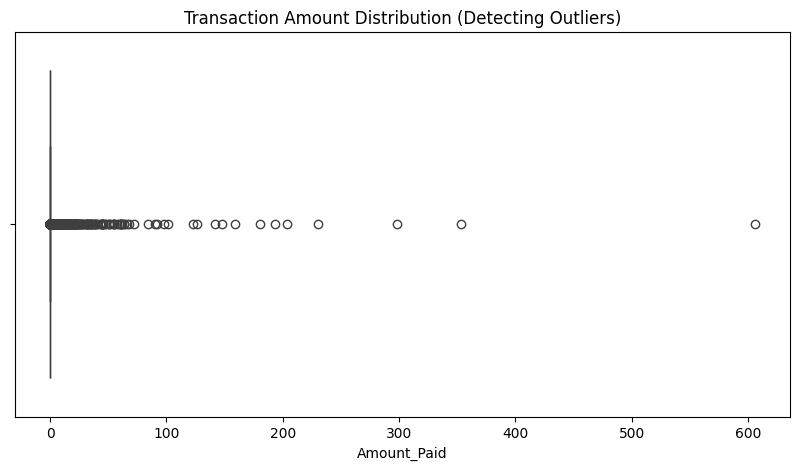

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load preprocessed data
df = pd.read_csv("IBM_AML_Preprocessed.csv")

# 🔹 Convert columns to correct data types
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors='coerce')  # Convert to datetime
df["Amount_Paid"] = pd.to_numeric(df["Amount_Paid"], errors='coerce')  # Convert to float
df["Amount_Received"] = pd.to_numeric(df["Amount_Received"], errors='coerce')  # Convert to float

# 1️⃣ Detect Rapid Transaction Bursts (Velocity Analysis)
df["Time_Diff"] = df.groupby("Sender_Account")["Timestamp"].diff().dt.total_seconds()
df["Is_Burst"] = df["Time_Diff"].apply(lambda x: 1 if pd.notna(x) and x < 60 else 0)  # Transactions < 1 min apart

# 2️⃣ Unusual Amounts (Amount Deviation)
df["Z_Score_Amount"] = (df["Amount_Paid"] - df["Amount_Paid"].mean()) / df["Amount_Paid"].std()
df["Is_Anomalous_Amount"] = df["Z_Score_Amount"].apply(lambda x: 1 if abs(x) > 3 else 0)  # Flag outliers beyond 3 std

# 3️⃣ Detect Circular Transactions (Same sender & receiver)
df["Is_Circular"] = df.apply(lambda x: 1 if x["Sender_Account"] == x["Receiver_Account"] else 0, axis=1)

# 4️⃣ Currency Arbitrage (Different currencies)
df["Currency_Arbitrage"] = df.apply(lambda x: 1 if x["Receiving_Currency"] != x["Payment_Currency"] else 0, axis=1)

# Visualize anomalies
plt.figure(figsize=(10, 5))
sns.boxplot(x=df["Amount_Paid"])
plt.title("Transaction Amount Distribution (Detecting Outliers)")
plt.show()


In [29]:
# Save flagged transactions
df.to_csv("Behavioral_Analysis_Results.csv", index=False)
print("Behavioral analysis completed! Flags added.")

Behavioral analysis completed! Flags added.


In [30]:
pip install python-louvain

Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9473 sha256=4f8e45030323c659897802e85f1a2ff741eb1406b100c2fc2f9cdf9dc06f647c
  Stored in directory: c:\users\keeer\appdata\local\pip\cache\wheels\ee\52\54\7ecd0f1ebf5f5a8466f70a27ed2b94d20b955376879d6159c5
Successfully built python-louvain
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
import networkx as nx
import pandas as pd
import numpy as np
from community import community_louvain
from tqdm import tqdm  # Progress bar for large computations

# Load dataset (ensure it is preprocessed correctly)
df = pd.read_csv("IBM_AML_Preprocessed.csv")

# Create a directed graph for transaction flow
G = nx.from_pandas_edgelist(df, source="Sender_Account", target="Receiver_Account", edge_attr="Amount_Paid", create_using=nx.DiGraph())

## **1️⃣ Approximate Degree Centrality (Faster)**
degree_centrality = dict(G.in_degree())  # Only in-degree (receiving transactions)
df["Degree_Centrality"] = df["Sender_Account"].map(degree_centrality)

## **2️⃣ Approximate PageRank (Faster Computation)**
pagerank_scores = nx.pagerank(G, alpha=0.85, max_iter=50)  # Limits iterations to 50 for speed
df["PageRank_Score"] = df["Sender_Account"].map(pagerank_scores)

## **3️⃣ Community Detection with Sampling (Louvain)**
# Instead of processing the entire graph, we process a **reduced subgraph** of active accounts
subgraph_nodes = set(df["Sender_Account"].sample(n=min(5000, len(df)), random_state=42))  # Sample 5000 nodes
G_sub = G.subgraph(subgraph_nodes)

partition = community_louvain.best_partition(G_sub.to_undirected())
df["Community_ID"] = df["Sender_Account"].map(partition).fillna(-1)  # Assign -1 to accounts not in the sample

## **4️⃣ Efficient Cycle Detection (Only for Suspicious Accounts)**
# Instead of detecting cycles for the whole graph, we check only high-risk nodes (based on PageRank score)
high_risk_accounts = df[df["PageRank_Score"] > df["PageRank_Score"].quantile(0.95)]["Sender_Account"].unique()
cycles_detected = set()

for account in tqdm(high_risk_accounts, desc="Detecting Cycles"):
    if account in G:
        try:
            cycles = list(nx.find_cycle(G, source=account, orientation="original"))  # Faster than `simple_cycles`
            if len(cycles) > 0:
                cycles_detected.add(account)
        except nx.NetworkXNoCycle:
            continue  # No cycle found

df["Is_Cyclic_Transaction"] = df["Sender_Account"].apply(lambda x: 1 if x in cycles_detected else 0)


Detecting Cycles: 100%|██████████| 1264/1264 [00:00<00:00, 146505.66it/s]


In [32]:
# Save graph-based features
df.to_csv("Graph_Analysis_Optimized.csv", index=False)

print("✅ Optimized Graph Analysis Completed!")

✅ Optimized Graph Analysis Completed!


In [33]:
pip install torch torchvision torch-geometric networkx pandas

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
    --------------------------------------- 2.9/204.1 MB 15.7 MB/s eta 0:00:13
   - -------------------------------------- 7.1/204.1 MB 18.9 MB/s eta 0:00:11
   -- ------------------------------------- 11.5/204.1 MB 19.4 MB/s eta 0:00:10
   --- ------------------------------------ 16.3/204.1 MB 20.4 MB/s eta 0:00:10
   ---- ----------------------------------- 22.8/204.1 MB 22.7 MB/s eta 0:00:08
   ----- ---------------------------------- 30.1/204.1 MB 25.0 MB/s eta 0:00:07
   ------- -------------------------------- 37.0/204.1 MB 26.1 MB/s eta 0:00:07
   -------- ------------------------------- 44.0/204.1 MB 27.2 MB/s eta 0:00:06
   ---------- ----------------------------- 52.2/204.1 MB 28.4 MB/s eta 0:00:06
   ------------ --------------------------- 61.3/204.1 MB 30.2 MB/s eta 0:00:05
   ------------- -------------------------- 68.9/204.


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
#GNN Graph analysis
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
import numpy as np

# Load preprocessed data
df = pd.read_csv("IBM_AML_Preprocessed.csv")

# 1️⃣ Create the Directed Graph for Transaction Network
G = nx.from_pandas_edgelist(df, source="Sender_Account", target="Receiver_Account", edge_attr="Amount_Paid", create_using=nx.DiGraph())

# 2️⃣ Map Accounts to Numeric Indices (for GNN compatibility)
account_mapping = {account: idx for idx, account in enumerate(G.nodes())}
df["Sender_Account_Index"] = df["Sender_Account"].map(account_mapping)
df["Receiver_Account_Index"] = df["Receiver_Account"].map(account_mapping)

# 3️⃣ Define Node Features (e.g., Account-based features)
node_features = {}
for node in G.nodes():
    node_features[node] = np.array([G.degree(node), np.mean([G[u][v]['Amount_Paid'] for u, v in G.edges(node)]) if len(list(G.edges(node))) > 0 else 0])  # Avoid empty edge list for mean

# Convert the node features to a torch tensor
node_feature_matrix = torch.tensor(list(node_features.values()), dtype=torch.float)

# 4️⃣ Build Edge Index (for PyG)
# Ensure numeric indices for edge index
edge_index = torch.tensor([(account_mapping[src], account_mapping[tgt]) for src, tgt in G.edges()], dtype=torch.long).t().contiguous()

# 5️⃣ Define Labels (1 for fraud, 0 for normal)
# For simplicity, we set labels randomly. In your case, labels would come from your dataset.
labels = torch.randint(0, 2, (len(G.nodes()),), dtype=torch.long)

# 6️⃣ Create PyTorch Geometric Data Object
data = Data(x=node_feature_matrix, edge_index=edge_index, y=labels)

# 7️⃣ Build the Graph Convolutional Network (GCN) Model
class GCN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)  # First layer
        self.conv2 = GCNConv(16, out_channels)  # Output layer (binary classification)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# 8️⃣ Initialize the GNN Model
model = GCN(in_channels=2, out_channels=2)  # 2 features for each node, output 2 classes (fraud or not)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# 9️⃣ Train the GNN Model
def train(model, data, optimizer, criterion, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

train(model, data, optimizer, criterion, epochs=200)

# 🔟 Evaluate the Model (Test set can be split in a real-world case)
model.eval()
out = model(data)
pred = out.argmax(dim=1)
accuracy = (pred == data.y).sum().item() / len(data.y)
print(f"Accuracy: {accuracy * 100:.2f}%")

C:\Users\keeer\AppData\Local\Temp\ipykernel_15020\298465671.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  node_feature_matrix = torch.tensor(list(node_features.values()), dtype=torch.float)


Epoch 0, Loss: 25.131481170654297
Epoch 10, Loss: 7.011607646942139
Epoch 20, Loss: 2.7564640045166016
Epoch 30, Loss: 2.023149251937866
Epoch 40, Loss: 1.7845275402069092
Epoch 50, Loss: 0.693501353263855
Epoch 60, Loss: 0.8479993939399719
Epoch 70, Loss: 1.1934115886688232
Epoch 80, Loss: 0.9727692008018494
Epoch 90, Loss: 1.0842887163162231
Epoch 100, Loss: 0.9889825582504272
Epoch 110, Loss: 1.1629835367202759
Epoch 120, Loss: 0.9458729028701782
Epoch 130, Loss: 1.0906466245651245
Epoch 140, Loss: 0.9933303594589233
Epoch 150, Loss: 1.138321042060852
Epoch 160, Loss: 0.934059739112854
Epoch 170, Loss: 1.0786429643630981
Epoch 180, Loss: 0.9803715348243713
Epoch 190, Loss: 1.1186147928237915
Accuracy: 50.09%


In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
import numpy as np

# Load preprocessed data
df = pd.read_csv("IBM_AML_Preprocessed.csv")

# 1️⃣ Create the Directed Graph for Transaction Network
G = nx.from_pandas_edgelist(df, source="Sender_Account", target="Receiver_Account", edge_attr="Amount_Paid", create_using=nx.DiGraph())

# 2️⃣ Map Accounts to Numeric Indices (for GNN compatibility)
account_mapping = {account: idx for idx, account in enumerate(G.nodes())}
df["Sender_Account_Index"] = df["Sender_Account"].map(account_mapping)
df["Receiver_Account_Index"] = df["Receiver_Account"].map(account_mapping)

# 3️⃣ Define Node Features
node_features = {node: np.array([G.degree(node),
                                 np.mean([G[u][v]['Amount_Paid'] for u, v in G.edges(node)])
                                 if len(list(G.edges(node))) > 0 else 0]) for node in G.nodes()}

# Convert the node features to a torch tensor
node_feature_matrix = torch.tensor(list(node_features.values()), dtype=torch.float)

# 4️⃣ Build Edge Index
edge_index = torch.tensor([(account_mapping[src], account_mapping[tgt]) for src, tgt in G.edges()], dtype=torch.long).t().contiguous()

# 5️⃣ Define Labels (Random for now, replace with actual fraud labels)
labels = torch.randint(0, 2, (len(G.nodes()),), dtype=torch.long)

# 6️⃣ Create PyTorch Geometric Data Object
data = Data(x=node_feature_matrix, edge_index=edge_index, y=labels)

# 7️⃣ Build the GCN Model
class GCN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# 8️⃣ Initialize the GNN Model
model = GCN(in_channels=2, out_channels=2)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# 9️⃣ Train the GNN Model
def train(model, data, optimizer, criterion, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

train(model, data, optimizer, criterion, epochs=200)

# 🔟 Extract Node Embeddings from the Trained Model
model.eval()
with torch.no_grad():
    node_embeddings = model.conv1(data.x, data.edge_index).numpy()

# Convert embeddings to DataFrame with correct number of columns
embedding_df = pd.DataFrame(node_embeddings, columns=[f"GNN_Embedding_{i+1}" for i in range(node_embeddings.shape[1])])

# Add account mapping
embedding_df["Sender_Account"] = list(account_mapping.keys())

# Save embeddings
embedding_df.to_csv("GNN_Node_Embeddings.csv", index=False)
print("GNN Node Embeddings Saved Successfully!")

Epoch 0, Loss: 10.474234580993652
Epoch 10, Loss: 1.5377274751663208
Epoch 20, Loss: 1.5812432765960693
Epoch 30, Loss: 1.0678766965866089
Epoch 40, Loss: 0.7380349636077881
Epoch 50, Loss: 0.718515932559967
Epoch 60, Loss: 0.6948429942131042
Epoch 70, Loss: 0.7064915895462036
Epoch 80, Loss: 0.7104066014289856
Epoch 90, Loss: 0.7130109071731567
Epoch 100, Loss: 0.7198626399040222
Epoch 110, Loss: 0.7216996550559998
Epoch 120, Loss: 0.7195293307304382
Epoch 130, Loss: 0.72109454870224
Epoch 140, Loss: 0.7218303084373474
Epoch 150, Loss: 0.7213998436927795
Epoch 160, Loss: 0.7219792008399963
Epoch 170, Loss: 0.7220170497894287
Epoch 180, Loss: 0.7220139503479004
Epoch 190, Loss: 0.7221583127975464
GNN Node Embeddings Saved Successfully!


In [36]:
import pandas as pd

# Load behavioral and graph-based data
behavioral_df = pd.read_csv("Behavioral_Analysis_Results.csv")
gnn_embeddings_df = pd.read_csv("GNN_Node_Embeddings.csv")

# Merge on Sender_Account (ensuring we match embeddings with accounts)
merged_df = pd.merge(behavioral_df, gnn_embeddings_df, on="Sender_Account", how="left")

# Save merged dataset
merged_df.to_csv("Merged_Behavioral_GNN_Features.csv", index=False)

print("Successfully Merged Behavioral & GNN Features!")

C:\Users\keeer\AppData\Local\Temp\ipykernel_15020\2399626798.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  behavioral_df = pd.read_csv("Behavioral_Analysis_Results.csv")


Successfully Merged Behavioral & GNN Features!


In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 1️⃣ Load the merged dataset (Behavior + Graph + GNN Features)
df = pd.read_csv("Merged_Behavioral_GNN_Features.csv")

# 2️⃣ Handle Missing Values
df.fillna(0, inplace=True)

# 3️⃣ Encode Categorical Variables (if any)
if df.select_dtypes(include=['object']).shape[1] > 0:
    label_encoders = {}
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype(str)  # Convert all categorical values to strings
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le  # Store for inverse transform if needed

# 4️⃣ Define Features (X) and Target (y)
target_col = "Is_Laundering"  # Corrected target column name
X = df.drop(columns=[target_col])  # Assuming "Is_Laundering" is the target column
y = df[target_col]

# 5️⃣ Split Data into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 6️⃣ Scale Features (Standardization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 7️⃣ Train Models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "LightGBM": lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
}

# 8️⃣ Evaluate Models
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probability scores for ROC-AUC

    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "AUC-ROC": roc_auc_score(y_test, y_prob)
    }

    results[name] = metrics
    print(f"\n🔹 Model: {name}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

# Convert results to DataFrame and save
results_df = pd.DataFrame(results).T
results_df.to_csv("Fraud_Detection_Model_Results.csv", index=True)

print("\n Fraud Detection Modeling Completed & Results Saved!")

C:\Users\keeer\AppData\Local\Temp\ipykernel_15020\259249215.py:11: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Merged_Behavioral_GNN_Features.csv")



🔹 Model: Random Forest
Accuracy: 0.9997
Precision: 0.9492
Recall: 0.4553
F1 Score: 0.6154
AUC-ROC: 0.8786

🔹 Model: XGBoost
Accuracy: 0.9997
Precision: 0.9365
Recall: 0.4797
F1 Score: 0.6344
AUC-ROC: 0.9824


C:\Users\keeer\AppData\Roaming\Python\Python313\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\keeer\AppData\Roaming\Python\Python313\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Python313\Lib\subprocess.py", line 556, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python313\Lib\subprocess.py", line 1038, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^

[LightGBM] [Info] Number of positive: 492, number of negative: 838368
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8113
[LightGBM] [Info] Number of data points in the train set: 838860, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000587 -> initscore=-7.440734
[LightGBM] [Info] Start training from score -7.440734


C:\Users\keeer\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\keeer\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🔹 Model: LightGBM
Accuracy: 0.9986
Precision: 0.2007
Recall: 0.4390
F1 Score: 0.2755
AUC-ROC: 0.8423

 Fraud Detection Modeling Completed & Results Saved!


In [39]:
!pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import optuna
from sklearn.metrics import f1_score

def objective(trial):
    scale_pos_weight = df["Is_Laundering"].value_counts()[0] / df["Is_Laundering"].value_counts()[1]
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "scale_pos_weight": scale_pos_weight,
        "gamma": trial.suggest_uniform("gamma", 0, 5),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 0.0001, 1),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 0.0001, 1),
    }

    model = XGBClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return f1_score(y_test, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best parameters:", study.best_params)

[I 2025-04-01 12:53:34,574] A new study created in memory with name: no-name-4b7954a5-d04f-41b1-b135-9eaffd68d54b
C:\Users\keeer\AppData\Local\Temp\ipykernel_15020\3173925449.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\keeer\AppData\Local\Temp\ipykernel_15020\3173925449.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\keeer\AppData\Local\Temp\ipykernel_15020\3173925449.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.

In [69]:
print("Best parameters:", study.best_params)

Best parameters: {'n_estimators': 375, 'max_depth': 10, 'learning_rate': 0.2890454831644262, 'subsample': 0.9571346193817639, 'colsample_bytree': 0.7794782252859026, 'gamma': 3.5127688378663686, 'reg_alpha': 0.0018903585601149047, 'reg_lambda': 0.004260973131397251}


In [87]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve

# 1️⃣ Load the merged dataset (Behavior + Graph + GNN Features)
df = pd.read_csv("Merged_Behavioral_GNN_Features.csv")

# 2️⃣ Handle Missing Values
df.fillna(0, inplace=True)

# 3️⃣ Encode Categorical Variables (if any)
if df.select_dtypes(include=['object']).shape[1] > 0:
    label_encoders = {}
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype(str)  # Convert all categorical values to strings
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le  # Store for inverse transform if needed

# 4️⃣ Define Features (X) and Target (y)
target_col = "Is_Laundering"  # Corrected target column name
X = df.drop(columns=[target_col])  # Assuming "Is_Laundering" is the target column
y = df[target_col]

# 5️⃣ Split Data into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Convert Data for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 6️⃣ Scale Features (Standardization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define Model Parameters
params = study.best_params

# 7️⃣ Train Models
# Train XGBoost with Custom Focal Loss
model = XGBClassifier(
    objective="binary:logistic",  # This ensures probability output
    eval_metric="logloss",
    use_label_encoder=False,  # Prevents warnings
    **params,  # Your tuned parameters
    random_state=42
)
# model = xgb.train(params, dtrain, num_boost_round=100)
model.fit(  X_train, y_train, eval_set=[(X_test, y_test)])


# 9️⃣ Evaluate Models
results = {}

# Predictions
# y_prob = model.predict(dtest)

y_probs = model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Optimal Threshold: {best_threshold:.4f}")

y_pred = (y_probs >= best_threshold).astype(int)

# Evaluate Model
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
    "AUC-ROC": roc_auc_score(y_test, y_prob)
}

# Print Results
print("\n🔹 Model with Focal Loss (XGBoost)")

results[name] = metrics
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Convert results to DataFrame and save
results_df = pd.DataFrame(results).T
results_df.to_csv("Fraud_Detection_Model_Results.csv", index=True)

print("\n Fraud Detection Modeling Completed & Results Saved!")

# !pip install optuna

<ipython-input-87-5675067e789f>:14: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Merged_Behavioral_GNN_Features.csv")
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:22:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-logloss:0.30308
[1]	validation_0-logloss:0.25301
[2]	validation_0-logloss:0.21423
[3]	validation_0-logloss:0.17159
[4]	validation_0-logloss:0.14158
[5]	validation_0-logloss:0.11866
[6]	validation_0-logloss:0.10477
[7]	validation_0-logloss:0.09146
[8]	validation_0-logloss:0.07961
[9]	validation_0-logloss:0.07055
[10]	validation_0-logloss:0.06413
[11]	validation_0-logloss:0.05750
[12]	validation_0-logloss:0.05253
[13]	validation_0-logloss:0.04969
[14]	validation_0-logloss:0.04480
[15]	validation_0-logloss:0.04129
[16]	validation_0-logloss:0.03752
[17]	validation_0-logloss:0.03438
[18]	validation_0-logloss:0.03253
[19]	validation_0-logloss:0.03003
[20]	validation_0-logloss:0.02863
[21]	validation_0-logloss:0.02754
[22]	validation_0-logloss:0.02588
[23]	validation_0-logloss:0.02477
[24]	validation_0-logloss:0.02428
[25]	validation_0-logloss:0.02317
[26]	validation_0-logloss:0.02234
[27]	validation_0-logloss:0.02168
[28]	validation_0-logloss:0.02105
[29]	validation_0-loglos

In [88]:
import joblib

# Save the trained model
joblib.dump(model, 'xgb_model.pkl')



['xgb_model.pkl']